In [1]:
import settings
import settings_update
from helpers import misc_helpers

RUN_SIZE = 'full'

print('loading train/test data')
settings.RUN_SIZE = RUN_SIZE
settings_update.update_run_size_setup()
X_train, y_train, X_val, y_val, X_test, y_test, X, y, scaler_y = misc_helpers.get_data(
    filepath=settings.DATA_FILEPATH,
    train_years=settings.TRAIN_YEARS,
    val_years=settings.VAL_YEARS,
    test_years=settings.TEST_YEARS,
    n_points_per_group=settings.N_POINTS_PER_GROUP,
    do_standardize_data=True,
)

y_train, y_val, y_test, y = map(scaler_y.inverse_transform, [y_train, y_val, y_test, y])
y_train, y_val, y_test, y = misc_helpers.make_arrs_1d(y_train, y_val, y_test, y)
print('done')

loading train/test data


C:\Users\Mischa\Desktop\Uni\Master\MA\code\my_code\helpers\misc_helpers.py:116: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  arr.drop(columns=ts_cols, inplace=True)  # todo: works bc no ts cols present?
C:\Users\Mischa\Desktop\Uni\Master\MA\code\my_code\helpers\misc_helpers.py:116: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  arr.drop(columns=ts_cols, inplace=True)  # todo: works bc no ts cols present?
C:\Users\Mischa\Desktop\Uni\Master\MA\code\my_code\helpers\misc_helpers.py:116: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://

done


In [4]:
import numpy as np

from helpers.io_helper import IO_Helper
from helpers.arr_helpers import get_method_to_arrs_gen

ARRAYS_FOLDER = 'arrays'
MODELS_FOLDER = 'models'

METHODS_WHITELIST = set([
    'qhgbr',
    'qr',
    'gp',
    'mvnn',
    'cp_hgbr',
    'cp_linreg',
    'cp_nn',
    'la_nn',
])
UQ_METHOD_TO_ARR_NAMES_DICT = {
    'qhgbr': [
        'native_qhgbr_y_pred_n210432_it0.npy',
        'native_qhgbr_y_quantiles_n210432_it0.npy',
        'native_qhgbr_y_std_n210432_it0.npy',
    ],
    'qr': [
        'native_quantile_regression_nn_y_pred_n210432_it300_nh2_hs50.npy',
        'native_quantile_regression_nn_y_quantiles_n210432_it300_nh2_hs50.npy',
        'native_quantile_regression_nn_y_std_n210432_it300_nh2_hs50.npy',
    ],
    'gp': [
        'native_gpytorch_y_pred_n210432_it200_new.npy',
        'native_gpytorch_y_quantiles_n210432_it200_new.npy',
        'native_gpytorch_y_std_n210432_it200_new.npy',
    ],
    'mvnn': [
        'native_mvnn_y_pred_n210432_it100_nh2_hs50.npy',
        'native_mvnn_y_quantiles_n210432_it100_nh2_hs50.npy',
        'native_mvnn_y_std_n210432_it100_nh2_hs50.npy',
    ],
    'cp_hgbr': [
        'posthoc_conformal_prediction_base_model_hgbr_y_pred_n210432_it5.npy',
        'posthoc_conformal_prediction_base_model_hgbr_y_quantiles_n210432_it5.npy',
        'posthoc_conformal_prediction_base_model_hgbr_y_std_n210432_it5.npy',
    ],
    'cp_linreg': [
        'posthoc_conformal_prediction_base_model_linreg_y_pred_n210432_it5.npy',
        'posthoc_conformal_prediction_base_model_linreg_y_quantiles_n210432_it5.npy',
        'posthoc_conformal_prediction_base_model_linreg_y_std_n210432_it5.npy',
    ],
    'cp_nn': [
        'posthoc_conformal_prediction_base_model_nn_y_pred_n210432_it5_cp2.npy',
        'posthoc_conformal_prediction_base_model_nn_y_quantiles_n210432_it5_cp2.npy',
        'posthoc_conformal_prediction_base_model_nn_y_std_n210432_it5_cp2.npy',
    ],
    'la_nn': [
        'posthoc_laplace_approximation_base_model_nn_y_pred_n210432_it1000_la2.npy',
        'posthoc_laplace_approximation_base_model_nn_y_quantiles_n210432_it1000_la2.npy',
        'posthoc_laplace_approximation_base_model_nn_y_std_n210432_it1000_la2.npy',
    ],
}


print('loading predictions')
io_helper = IO_Helper(arrays_folder=ARRAYS_FOLDER, models_folder=MODELS_FOLDER)

n_test_samples = y_test.shape[0]

uq_method_to_arrs_gen = get_method_to_arrs_gen(
    methods_whitelist=METHODS_WHITELIST,
    method_to_arr_names_dict=UQ_METHOD_TO_ARR_NAMES_DICT,
    io_helper=io_helper,
)
uq_method_to_arrs_dict = dict(uq_method_to_arrs_gen)
print('done')

loading predictions
done


In [5]:
# compute calibrations

print('computing calibrations')

y_test_rep = np.vstack([y_test] * len(settings.QUANTILES))
y_test_rep = y_test_rep.transpose()

method_calibrations = {}
for method, arrs in uq_method_to_arrs_dict.items():
    y_pred, y_quantiles, y_std = arrs
    y_pred_test, y_quantiles_test, y_std_test = [arr[-n_test_samples:] for arr in arrs]

    calibration_arr = (y_test_rep <= y_quantiles_test)
    calibration_vals = calibration_arr.mean(axis=0)
    method_calibrations[method] = calibration_vals
print('done')

computing calibrations
done


plotting native
plotting qr
plotting qhgbr
plotting mvnn
plotting mvnn
plotting gp
plotting posthoc
plotting cp_linreg
plotting cp_hgbr
plotting cp_nn
plotting la_nn


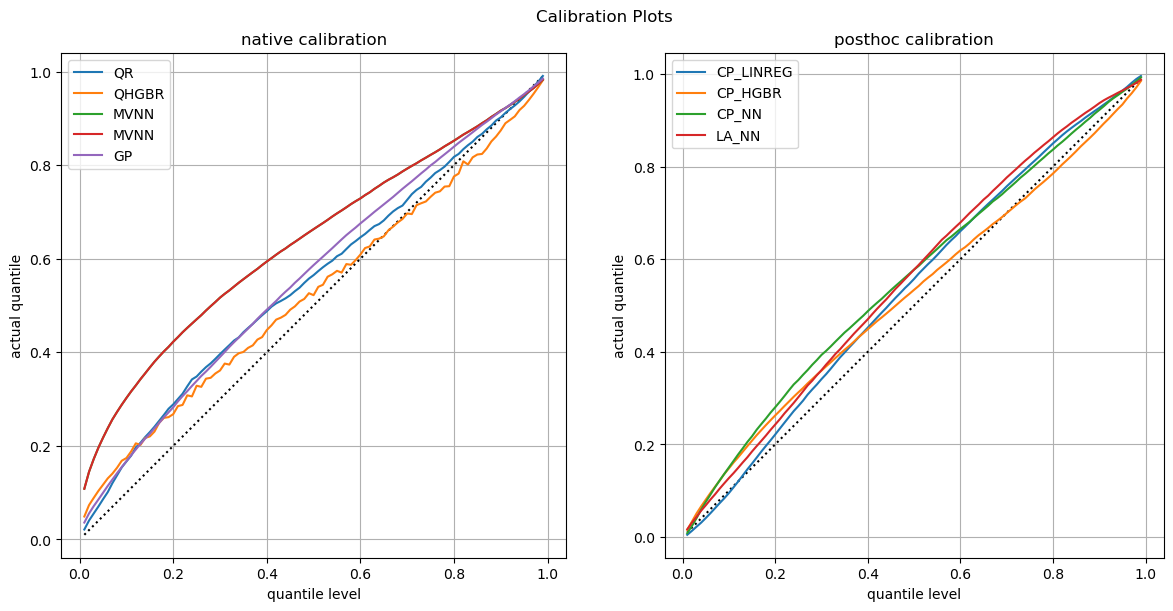

In [7]:
import matplotlib.pyplot as plt

DPI = 100
FILEPATH = 'comparison_storage/plots/calibration_plot.png'


METHOD_TYPE_DICT = {
    'native': ['qr', 'qhgbr', 'mvnn', 'mvnn', 'gp'],
    'posthoc': ['cp_linreg', 'cp_hgbr', 'cp_nn', 'la_nn']
}
COLORS = plt.rcParams['axes.prop_cycle'].by_key()['color']

x_plot = settings.QUANTILES
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 6), layout='constrained', dpi=DPI)
fig.suptitle('Calibration Plots')
for ax, (method_type, methods) in zip(axs, METHOD_TYPE_DICT.items()):
    print(f'plotting {method_type}')
    ax.set_aspect('equal')
    ax.plot(x_plot, x_plot, linestyle='dotted', color='black')
    ax.set_title(f'{method_type} calibration')
    ax.set_xlabel('quantile level')
    ax.set_ylabel('actual quantile')
    ax.grid(True)

    for method, color in zip(methods, COLORS):
        print(f'plotting {method}')
        calibrations = method_calibrations[method]
        ax.plot(x_plot, calibrations, label=method.upper())
    ax.legend()

if FILEPATH is not None:
    plt.savefig(FILEPATH)

In [26]:
def sanity_check(from_=0, to=10, quantile_perc=50, verbose=True):
    method, arrs = next(iter(uq_method_to_arrs_dict.items()))
    y_pred, y_quantiles, y_std = arrs
    y_pred_test, y_quantiles_test, y_std_test = [arr[-n_test_samples:] for arr in arrs]
    calibration_arr = (y_test[from_:to] <= y_quantiles_test[from_:to, quantile_perc-1])
    calibration_vals = calibration_arr.mean(axis=0)

    if verbose:
        print(f'y test:\n{np.round(y_test[from_:to], 1)}')
        print(f'y quantiles:\n{np.round(y_quantiles_test[from_:to, quantile_perc-1], 1)}')
        print(f'calibration:\n{calibration_arr}')
    print(f'mean: {calibration_vals}')

# sanity_check(-15, None)  # successful...

y test:
[11800.5 11677.8 11574.5 11522.2 11339.5 11242.2 11134.5 11191.5 11117.2
 11008.5 10782.  10753.8 10606.8 10495.8 10289.2]
y quantiles:
[12192.1 12010.8 11724.  11554.7 11403.  11323.  11276.9 11399.9 11196.7
 11003.9 10811.7 10561.  10465.4 10417.5 10105.1]
calibration:
[ True  True  True  True  True  True  True  True  True False  True False
 False False False]
mean: 0.6666666666666666


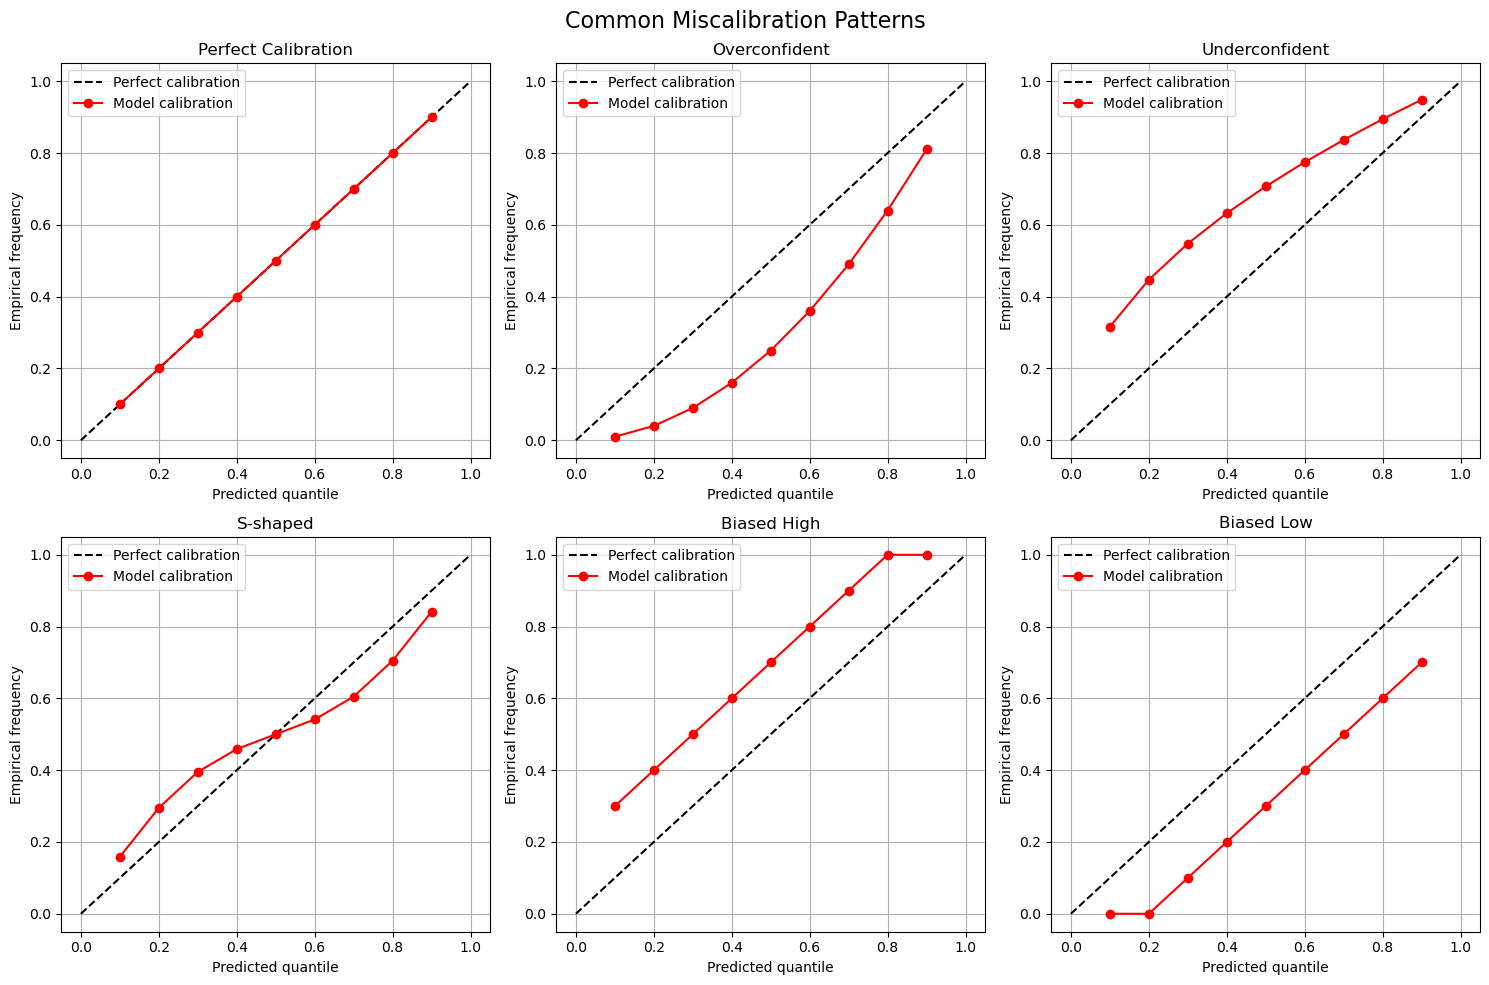

In [31]:
# code by claude

import numpy as np
import matplotlib.pyplot as plt

def plot_calibration_patterns():
    # Create quantile levels
    quantile_levels = np.linspace(0.1, 0.9, 9)
    
    # Perfect calibration
    perfect = quantile_levels
    
    # Different miscalibration patterns
    overconfident = quantile_levels ** 2  # Points below diagonal
    underconfident = np.sqrt(quantile_levels)  # Points above diagonal
    s_shaped = quantile_levels + 0.1 * np.sin(2 * np.pi * quantile_levels)  # S-curve
    biased_high = np.minimum(quantile_levels + 0.2, 1)  # Shifted up
    biased_low = np.maximum(quantile_levels - 0.2, 0)  # Shifted down
    
    # Create subplot for each pattern
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    fig.suptitle('Common Miscalibration Patterns', fontsize=16)
    
    # Plot each pattern
    patterns = {
        'Perfect Calibration': perfect,
        'Overconfident': overconfident,
        'Underconfident': underconfident,
        'S-shaped': s_shaped,
        'Biased High': biased_high,
        'Biased Low': biased_low
    }
    
    for (title, pattern), ax in zip(patterns.items(), axes.flat):
        ax.plot([0, 1], [0, 1], 'k--', label='Perfect calibration')
        ax.plot(quantile_levels, pattern, 'o-r', label='Model calibration')
        ax.set_xlabel('Predicted quantile')
        ax.set_ylabel('Empirical frequency')
        ax.set_title(title)
        ax.grid(True)
        ax.legend()
        
    plt.tight_layout()
    plt.show()

plot_calibration_patterns()